<p align = "justify">Giuseppe Giadone, 5110222.</p>
<p align = "justify">Andrea Tuscano, 5005657.</p>
<p align = "justify">Fabrizio Lanubile, 5107565.</p>

##Introduction
<p align = "justify">This notebook has the goal of building a Natural Language Processing pipeline. This is going to be composed of three parts: Exploratory Data Analysis, application of a Recurrent Neural Network for named entity recognition, and classification exploiting a BERT transformer. The dataset on which these are applied is <i>wikigold</i>, a collection of wikipedia articles annotated with IOB labels.</p>

##Exploratory Data Analysis

We access our Google Drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Text Mining Project/

Mounted at /content/drive
/content/drive/MyDrive/NLP9_2_notebooks


We load necessary modules.

In [ ]:
#!pip install seqeval
#!pip install matplotlib
#!pip install transformers
import matplotlib.pyplot as plt
import urllib
import sklearn
import logging
import os
import random
import numpy as np
import pandas as pd
import plotly.express as px

import spacy
from spacy import displacy
from spacy.tokens import Doc


We open the annotated text file "wikigold.txt" specifying the encoding (utf-8).

In [ ]:
stri = open('/content/drive/MyDrive/Text Mining Project/wikigold.txt','r', encoding="utf8")
wikigold_lines = stri.readlines()
stri.close()

We then write a function that taking the array of lines from our document is able to first split it into several documents, and then shuffle the data and re-write it into three .txt files. These files are our training, validation and test set.

In [ ]:
def train_valid_test(lines):
  newlines = []
  newlines.append("")
  for i in range(len(lines)):
    if ("-DOCSTART-" in lines[i]):
        newlines.append("")
    newlines[-1] = newlines[-1] + lines[i]
  #cut out last -DOCSTART-
  newlines = newlines[0:(len(newlines)-1)]

  #some formatting
  for i in range(len(newlines)):
    newlines[i] = newlines[i].replace("-DOCSTART- O", "")
  
  sample = random.sample(newlines, 44)
  test = sample[0:22]
  valid = sample[23:44]

  train = []
  for i in range(len(newlines)):
    check = True
    for j in range(len(valid)):
        if (newlines[i] == valid[j]) or (newlines[i] == test[j]):
            check = False
            break
    if check:
        train.append(newlines[i])

  #writing validation set into a txt
  list_to_string = ""
  for i in range(len(valid)):
    list_to_string = list_to_string + valid[i]

  textfile = open('datasets/valid.txt', 'w', encoding="utf8")
  textfile.write(list_to_string)
  textfile.close()

  #writing test set into a txt
  list_to_string = ""
  for i in range(len(test)):
    list_to_string = list_to_string + test[i]

  textfile = open('datasets/test.txt', 'w', encoding="utf8")
  textfile.write(list_to_string)
  textfile.close()

  #writing training set into a txt
  list_to_string = ""
  for i in range(len(train)):
    list_to_string = list_to_string + train[i]

  textfile = open('datasets/train.txt', 'w', encoding="utf8")
  textfile.write(list_to_string)
  textfile.close()

We run the function with wikigold.txt.

In [ ]:
#train_valid_test(wikigold_lines)

###Part of Speech

Part of Speech (PoS) aims to find a category to which a word is assigned in accordance with its syntactic functions.

Let's see how our dataset is composed by looking at its first rows through the head() function.

In [ ]:
df = pd.read_csv('wikigold.txt',sep=' ', header = None)
df.head()

,0,1
0,010,I-MISC
1,is,O
2,the,O
3,tenth,O
4,album,O


Here we can see, retrieving the values from the category list, how many of them are in the dataset that we take in consideration.

In [ ]:
col_list = df[1].values.tolist()
print(col_list)
print(len(col_list))

['I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'I-MISC', 'O', 'I-MISC', 'O', 'O', 'O', 'I-PER', 'I-PER', 'O', 'O', 'O', 'I-MISC', 'I-MISC', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'O', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'I-MISC', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ORG', 'O', 'O', 'O', 'I-LOC', 'I-LOC', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', '

However, we'll take a closer look to POS tags (noun, verb, adjective) and fine-grained tags (plural noun, past-tense verb, superlative adjective), rather than NER that we'll look later.

Since same words in a different order can mean something completely different, it's usually better to use linguistic knowledge to add useful information. That's exactly what spaCy is designed to do: you put in raw text, and get back a **Doc** object, that comes with a variety of annotations.

In [ ]:
nlp = spacy.load('en_core_web_sm')

doc = nlp(u'010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets.')
# Counting the frequencies of different coarse-grained POS tags:
POS_counts = doc.count_by(spacy.attrs.POS)
POS_counts

{93: 1, 87: 1, 90: 2, 84: 3, 92: 2, 85: 1, 96: 4, 97: 1}

For every index position there is the associated Part of Speech tag, for instance:

In [ ]:
doc.vocab[87].text # returns the associated pos tag

'AUX'

In [ ]:
# Create a frequency list of POS tags from the entire document
for k,v in sorted(POS_counts.items()):
    print(f'{k}. {doc.vocab[k].text:{5}}: {v}')

84. ADJ  : 3
85. ADP  : 1
87. AUX  : 1
90. DET  : 2
92. NOUN : 2
93. NUM  : 1
96. PROPN: 4
97. PUNCT: 1


The dependency parse shows the coarse POS tag for each token.



In [ ]:
doc = nlp(u'010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets.')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 110})

In [ ]:
for token in doc:
    print(f'{token.text:{10}} {token.pos_:{7}} {token.dep_:{7}} {spacy.explain(token.dep_)}')

010        NUM     nsubj   nominal subject
is         AUX     ROOT    root
the        DET     det     determiner
tenth      ADJ     amod    adjectival modifier
album      NOUN    attr    attribute
from       ADP     prep    prepositional modifier
Japanese   ADJ     amod    adjectival modifier
Punk       PROPN   compound compound
Techno     PROPN   compound compound
band       NOUN    pobj    object of preposition
The        DET     det     determiner
Mad        ADJ     amod    adjectival modifier
Capsule    PROPN   compound compound
Markets    PROPN   appos   appositional modifier
.          PUNCT   punct   punctuation


###Named Entities


A named entity is a real-world object, such as a person, location, organization, product, etc., that can be denoted with a proper name.

spaCy has an 'ner' pipeline component that identifies token spans fitting a predetermined set of named entities.


In [ ]:
doc = nlp(u"""Thirty Seconds to Mars is an alternative rock band, featuring Jared Leto, Shannon Leto, Tomo Milicevic.""")
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
stri=open("wikigold_labels.txt",'r',encoding='utf8')
wikigold_labels=stri.readlines()
stri.close()

In [ ]:
unique=[]
for i in wikigold_labels:
  if i not in unique:
    unique.append(i)

unique[0] = unique[0].replace(" I-MISC\n", "I-MISC")
unique[1] = unique[1].replace(" O\n", "O")
unique[2] = unique[2].replace(" I-ORG\n", "I-ORG")
unique[3] = unique[3].replace(" I-PER\n", "I-PER")
unique[4] = unique[4].replace(" I-LOC\n", "I-LOC")

In [ ]:
d=wikigold_labels.count(' O\n')
i=wikigold_labels.count(' I-MISC\n')
o=wikigold_labels.count(' I-ORG\n')
c=wikigold_labels.count(' I-PER\n')
h=wikigold_labels.count(' I-LOC\n')

In [ ]:
conta=[]

conta.append(i)
conta.append(d)
conta.append(o)
conta.append(c)
conta.append(h)

Here we can see how the different Named Entities Categories are distributed through the 'wikigold' dataset.

In [ ]:
fig = px.bar(x = unique, y = conta, text_auto='.2s', color = unique)
fig.show()

Removing all the 'O' we can see the differences:

In [ ]:
unique.remove('O')
conta.remove(32721)
fig = px.bar(x = unique, y = conta, text_auto='.2s', color = unique)
fig.show()

###Topics Modelling

<p align = "justify">The goal of this section is to apply Latent Dirichlet Allocation and Non-negative Matrix Factorization to explore our dataset and see if we can highlight reccurent topics in our articles.</p>
<p align = "justify">Latent Dirichlet Allocation works on the premise that topics, within a document for example, are defined by usage of specific groups of words (we can see documents as "bags of words"). Documents then can be seen as being distributions over topics, and topics over words, all tied within a probabilistic system.</p>
<p align = "justify">We access our Google Drive folder.</p>

In [ ]:
#we clean the runtime with the reset magic command
%reset -f

from google.colab import drive #autorizzazione ad accedere al tuo Drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Text Mining Project/

Mounted at /content/drive
/content/drive/MyDrive/Text Mining Project


<p align = "justify">We now need to import necessary modules, such as <i>pandas</i> to build our dataframes, <i>spacy</i> to perform text manipulation (tokenization, lemmatization etc.), <i>scikit-learn</i> for vectorization.</p>

In [ ]:
#pandas
import pandas as pd
#spacy
import spacy
#import LDA modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#import NMF modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
#numpy
import numpy as np
#seaborn
import seaborn as sns
import matplotlib.patches as mpatches
#import matplot
!pip install matplotlib
import matplotlib.pyplot as plt
#statistics
import statistics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<p align = "justify">After these preliminary passages we can work more directly on our corpus.</p>

####Pre-processing
<p align = "justify">We load our text from the file <i>wikigold_raw</i> considering it line by line. Take care, we are not considering the annotated corpus, but a version from which annotations were pulled out. Annotations are not going to be subject of this analysis and shouldn't be considered. The raw text is what we will be focusing on.</p>

In [ ]:
stri = open('wikigold_raw.txt','r', encoding="utf8")
wikigold_lines = stri.readlines()
stri.close()

<p align = "justify">The custom function <i>splitter</i> subdivides our "raw" text file into separate documents and outputs them as a list of strings. Each string is a new document. From these documents only <i>-DOCSTART-</i> strings and line-break characters were pulled out as they would not be useful anymore.</p>

In [ ]:
def splitter(lines):
  newlines = []
  newlines.append("")
  #for each line we read, compile everything in a string until you read '-DOCSTART-'
  for i in range(len(lines)):
    #when '-DOCSTART-' is read, append a new string to our list and work on that one
    if ("-DOCSTART-" in lines[i]):
        newlines.append("")
    newlines[-1] = newlines[-1] + lines[i]
  #cut out the last -DOCSTART-
  newlines = newlines[0:(len(newlines)-1)]

  #for each document remove -DOCSTART- and useless linefeeds
  for i in range(len(newlines)):
    newlines[i] = newlines[i].replace("-DOCSTART-", "")
    newlines[i] = newlines[i].replace("\n", "")
  
  return newlines

<p align = "justify">We run the function and check that the first document is indeed the correct one.</p>

In [ ]:
my_text = splitter(wikigold_lines)
print(my_text[0])

010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets. This album proved to be more commercial and more techno-based than Osc-Dis, with heavily synthesized songs like Introduction 010 and Come. Founding member Kojima Minoru played guitar on Good Day, and Wardanceis cover of a song by UK post punk industrial band Killing Joke. XXX can of This had a different meaning, and most people did n't understand what the song was about. it was later explained that the song was about Cannabis (' can of this' sounding like Cannabis when said faster ) it is uncertain if they were told to change the lyric like they did on P.O.P and HUMANITY. UK Edition came with the OSC-DIS video, and most of the tracks were re-engineered. 


<p align = "justify">The presence of The Mad Capsule Markets reassures us that the function has worked, but we might also be wanting to check that the last document is correct.</p>

In [ ]:
my_text = splitter(wikigold_lines)
print(my_text[-1])

 Oleg Mikhaylovich Gazmanov is a Russian singer. 


<p align = "justify">So far, so good.</p>

####Data Cleaning and Lemmatization
<p align = "justify">The goal now is to remove useless terms, or "stopwords", that might hinder our analysis. To do this, we will rely especially on the module <i>spacy</i>, as it provides ready-made vocabularies. As the task at hand is rather simple, it was decided to load <i>spacy</i>'s small trained pipeline.</p>

In [ ]:
nlp = spacy.load('en_core_web_sm')

<p align = "justify">Here, we cycle through every document, and within each document we iterate over each token, keeping only those not flagged as stopwords within <i>spacy</i>'s pipeline. Furthermore, as each token is re-inserted within our document, a blank space separator is introduced. We also take care to manually remove punctuation, as it is not deemed necessary for Latent Dirichlet Annotation.</p>

In [ ]:
#for each document in the dataset run this
for i in range(len(my_text)):
  my_line = nlp(my_text[i])
  my_tokens = list(my_line)
  current_line = []
  #for each token in document i run this
  for word in my_tokens:
    #if the token is a stop-word, skip it
    if nlp.vocab[word.text].is_stop:
      continue
    else:
      current_line.append(word)

  current_string = ""
  #for each word 
  for word in current_line:
    #each token is re-inserted in a string, a blank space is placed in between each token
    current_string = current_string + " " + word.text

  #some manual cleaning is applied to our string
  current_string = current_string.replace(",", "")

  #careful here, we remove periods, they are not useful in this part but might be later
  current_string = current_string.replace(".", "")
    
  current_string = current_string.replace("!", "")
  current_string = current_string.replace("?", "")
  current_string = current_string.replace("(", "")
  current_string = current_string.replace(")", "")
  current_string = current_string.replace("%", "")
  current_string = current_string.replace("&", "")
  current_string = current_string.replace("-", "")
  current_string = current_string.replace('"', "")
  current_string = current_string.replace("'", "")

  #remove any multiple spaces
  current_space = " "
  for index in range(30):
    current_space = current_space + " "
    current_string = current_string.replace(current_space, " ")


  #lowercasing is applied to each string
  current_string = current_string.lower()
  my_text[i] = current_string

<p align = "justify">We can now go back to our first document and see what has happened to the Mad Capsule Markets.</p>

In [ ]:
print(my_text[0])

 010 tenth album japanese punk techno band mad capsule markets album proved commercial techno based osc dis heavily synthesized songs like introduction 010 come founding member kojima minoru played guitar good day wardanceis cover song uk post punk industrial band killing joke xxx different meaning people understand song later explained song cannabis  sounding like cannabis said faster uncertain told change lyric like pop humanity uk edition came osc dis video tracks engineered 


<p align = "justify">And now the last doc.</p>

In [ ]:
print(my_text[-1])

  oleg mikhaylovich gazmanov russian singer 


<p align = "justify">Many words which have very similar meaning might be found within natural language. Reducing them to their basic form, or lemma, helps us in performing better Topics Modelling analysis. We therefore apply the process of "Lemmatization" to our document.</p>
<p align = "justify">The structure of this process is very similar to the previous. We will be using <i>spacy</i>'s pipeline and with it reduce its word to its lemma, then re-inserting it with its document.</i>

In [ ]:
#for each document run this
for i in range(len(my_text)):
  #tokenization
  my_line = nlp(my_text[i])
  current_string = ""
  #for each token in document i run this
  for j in range(len(my_line)):
    #add lemmas
    current_string = current_string + " " + my_line[j].lemma_
  my_text[i] = current_string

<p align = "justify">We then do our usual check and see what has changed in the first article.</p>

In [ ]:
print(my_text[0])

   010 tenth album japanese punk techno band mad capsule market album prove commercial techno base osc dis heavily synthesize song like introduction 010 come found member kojima minoru play guitar good day wardanceis cover song uk post punk industrial band killing joke xxx different mean people understand song later explain song cannabis   sound like cannabi say fast uncertain tell change lyric like pop humanity uk edition come osc dis video track engineer


<p align = "justify">And the last.</p>

In [ ]:
print(my_text[-1])

    oleg mikhaylovich gazmanov russian singer


<p align = "justify">We are now able to begin the Latent Dirichlet Allocation with a proper dataset.</p>

####Latent Dirichlet Allocation

<p align = "justify">As was stated previously, the goal in this chapter is to cluster our document regarding topics. The first thing we should do is input our text into a <i>pandas</i> dataframe, so that we can better work on it. We output the first 10 articles of our corpus.</p>

In [ ]:
my_df = pd.DataFrame (my_text, columns = ['Wikipedia Articles'])
my_df.head(10)

,Wikipedia Articles
0,010 tenth album japanese punk techno band m...
1,139th form camp howe near pittsburgh septe...
2,1896 atlantic city rail crash occur shortl...
3,2007 bowling green falcon football team re...
4,30 second mar thirty second mar alternativ...
5,38th naacp image award honor good film tel...
6,65th wing subordinate unit transfer englan...
7,6pr known 882 6pr commenced broadcasting o...
8,883jia fm chinese radio station safra radi...
9,aabenraa county province denmark locate ea...


<p align = "justify">We would like to visualize how the length of each document is distributed in our corpus. We want to know at a glance if we should expect many long documents, or if instead the articles are more uniformly distributed. We can achieve this by employing a simple histogram, on which a density line is plotted. It was also decided to add a vertical line indicating the mean length of our articles.</p>

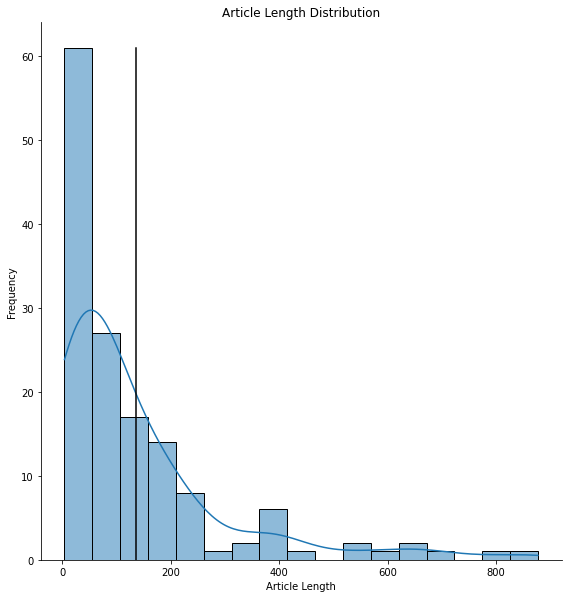

In [ ]:
my_df["Words_Per_Article"] = my_df["Wikipedia Articles"].str.split().apply(len)
n_words_list = my_df['Words_Per_Article'].values.tolist()

word_mean = statistics.mean(n_words_list)
sns.displot(n_words_list, height = 8, kind = "hist", kde = True)
plt.title("Article Length Distribution")
plt.xlabel("Article Length")
plt.ylabel("Frequency")

plt.plot([word_mean, word_mean], [0, 61], color = "k")

del my_df['Words_Per_Article']

<p align = "justify">What our plot tells us is that while most documents are of similar length, there are a few outliers considerably longer than the rest. This might be a problem for this and future analysis.</p>
<p align = "justify">The chosen method of vectorization for LDA follows a bag-of-words logic. We count the occurances of words within our document using the function CountVectorizer(.).  When we apply the CountVectorizer(.) function, we can observe that if we only include tokens present in at least 20% of our documents we are actually cutting out the vast majority of words. We therefore proceed with a more relaxed minimum threshold of 8%. The maximum threshold is 30%, while this may seem very low, it does not impact the number of tokens available at all. The choice to keep it low was made so as to be a reminder that in our case it does not affect the process. Of course, the user will want to tune these specifically for their own corpus.</p>

In [ ]:
cv = CountVectorizer(max_df=0.3, min_df=0.08, stop_words='english') #setting the threshold higher than 0.3 changes nothing
#another indication there aren't many recurrent terms
dtm = cv.fit_transform(my_df['Wikipedia Articles'])
dtm

<145x113 sparse matrix of type '<class 'numpy.int64'>'
	with 1879 stored elements in Compressed Sparse Row format>

<p align = "justify">Trying to fit our corpus into three topics seems like the best idea. This is the result of a lot of empirical trial and error. Increasing the number of topics leads to consistent repetition in the resulting most important terms, while decreasing below three renders our analysis rather useless.</p>

In [ ]:
#n_topics is important, it lets us decide in how many topics we want to split the corpus
#the rest of the analysis, and relative barplot, are both generalized with respect to this variable
n_topic = 3

LDA = LatentDirichletAllocation(n_components=n_topic,random_state=88)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=88)

<p align = "justify">The output here describes the dimensions of our model and the seed used for randomization. By applying a seed we can replicate our result, this is important both for tuning and transparency.</p>

<p align = "justify">Having performed our Latent Dirichlet Allocation, the first thing we would like to observe is the eight most important terms per topic. This also does help us in understanding what our topics might be about, and finally gather some information from our analysis.</p>

In [ ]:
for index,topic in enumerate(LDA.components_):
  n_words = 8
  print(f'Top {n_words} words in topic #{index}:')
  print([cv.get_feature_names()[i] for i in topic.argsort()[-n_words:]])
  print('\n')

Top 8 words in topic #0:
['game', 'american', 'bear', 'university', 'team', 'year', 'play', 'league']


Top 8 words in topic #1:
['locate', 'people', 'day', 'world', 'village', 'city', 'station', 'player']


Top 8 words in topic #2:
['2007', 'october', 'record', 'include', 'release', 'music', 'album', 'band']




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<p align = "justify">The first topic seems to be related to competition, or sports. We can see words such as "team", "year", and "league". Topic #1 instead seems to focus on more general terms, perhaps "south", "village", "city", might indicate a propensity towards geographical or historical terms. The words in the last topic instead seem to be more related to artistic endeavours, or music.</p>
<p align = "justify">We can now use these results and choose for each wikipedia article the most likely topic it might belong to considering the tokens it is composed of.</p>

In [ ]:
#for every document, choose the most likely topic
topic_results = LDA.transform(dtm)
topic_results.shape
argmax = topic_results.argmax(axis=1)
argmax = list(argmax)

<p align = "justify">We can therefore see for each document which topic is the most likely to belong to. A sample of texts is taken, and to their right a new column has been added that contains the most probable topic.</p>

In [ ]:
n_head = 10

my_df['Topic'] = argmax
my_df.head(n_head)

,Wikipedia Articles,Topic
0,010 tenth album japanese punk techno band m...,2
1,139th form camp howe near pittsburgh septe...,1
2,1896 atlantic city rail crash occur shortl...,1
3,2007 bowling green falcon football team re...,0
4,30 second mar thirty second mar alternativ...,2
5,38th naacp image award honor good film tel...,2
6,65th wing subordinate unit transfer englan...,2
7,6pr known 882 6pr commenced broadcasting o...,1
8,883jia fm chinese radio station safra radi...,1
9,aabenraa county province denmark locate ea...,1


<p align = "justify">Then, we should include our results in an easily readable form for future use. We compile the topic frequency within a list.  We can see topic 0 and 1 are almost equally frequent, whereas topic 2 is about half as present.</p>

In [ ]:
topic_list = my_df['Topic'].values.tolist()

my_count = []
for i in range(n_topic):
  my_count.append(0)

for i in range(len(topic_list)):
  for j in range(len(my_count)):
    if int(topic_list[i]) == j:
      my_count[j] = my_count[j] + 1
print(my_count)

[59, 57, 29]


<p align = "justify">It would not be sufficient to simply show a numerical representation of our result, therefore, we need to employ some visualization tools. We start with a simple barplot, this aids us in understanding more intuitively how our LDA has acted.</p>

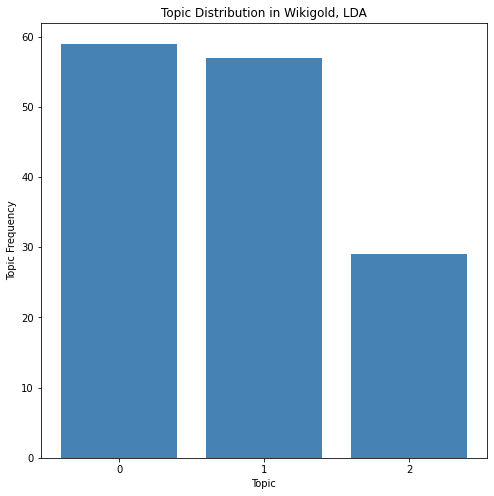

In [ ]:
my_topics = []
for i in range(len(my_count)):
  my_topics.append(f'{i}')

plt.figure(figsize=(8,8))
plt.bar(my_topics, my_count, color = "steelblue")

plt.title("Topic Distribution in Wikigold, LDA")
plt.ylabel("Topic Frequency")
plt.xlabel("Topic")

plt.show()

<p align = "justify">We might also be interested in seeing the relative frequencies, expressed as percentages, of our topic distribution. We employ a donut plot to perform this action.</p>

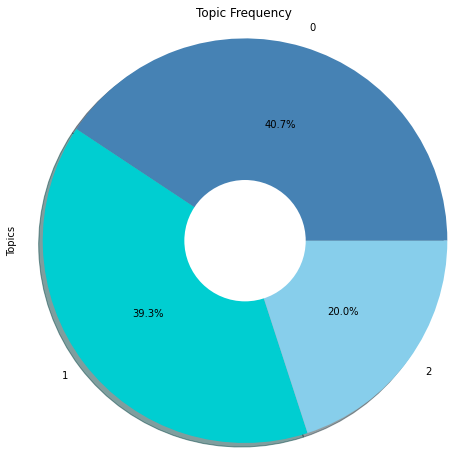

In [ ]:
count_df = pd.DataFrame(my_count, columns = ["Topics"])
count_df_labels = my_topics
count_df_colors = ['steelblue', 'darkturquoise', 'skyblue']
count_df['Topics'].plot(kind='pie',figsize=(8, 8),autopct='%1.1f%%',labels=count_df_labels, colors = count_df_colors, shadow=True)

centre_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Topic Frequency')
plt.axis('equal')

plt.show()

<p align = "justify">If we wanted to be more precise in our visualization, we could use a waffle plot to see the situation case by case. Therefore, we define the function <i>create_waffle_chart</i>.</p>

In [ ]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]
    
    waffle_chart = np.zeros((height, width))

    category_index = 0
    tile_index = 0

    for col in range(width):
        for row in range(height):
            tile_index += 1

            if tile_index > sum(tiles_per_category[0:category_index]):
                category_index += 1       
            
            waffle_chart[row, col] = category_index
    
    fig = plt.figure()

    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    ax = plt.gca()

    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    #legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = "Topic " + category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = "Topic " + category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )
    plt.show()

<p align = "justify">Width and height must multiply to an integer number representing the total number of documents considered. The plot is indeed a matrix, in which each cell is a document, and where the colors indicate to which topic each article belongs to.</i>

Total number of tiles is 145


<Figure size 432x288 with 0 Axes>

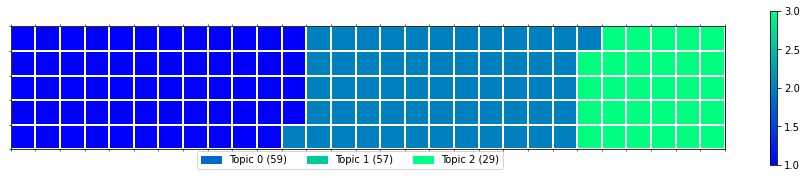

In [ ]:
width = 29
height = 5
categories = my_topics
values = count_df['Topics']
colormap = plt.cm.winter

create_waffle_chart(categories, values, height, width, colormap)

<p align = "justify">While these results seem satisfactory, we can see what happens if we apply a similar method such as NMF</i>.

####Non-Negative Matrix Factorization
<p align = "justify">Non-Negative Matrix Factorization is applied with an objective equivalent to that of Latent Dirichlet Allocation. An important difference between the two is how tokens are vectorized. Whereas for LDA we have a bag-of-words approach, in NMF we follow a term-frequence/inverse term-frequency paradigm (TF-IDF). The most common terms are counted, but their importance is lessened by applying a logarithmic scaling to the inverse fraction that contain the token. <i>Scikit-learn</i> will be used for this task.</p>
<p align = "justify">We first input our articles within a pandas dataframe.</p>

In [ ]:
my_df = pd.DataFrame (my_text, columns = ['Wikipedia Articles'])

<p align = "justify">The thresholds considered for TF-IDF vectorization were chosen with a similar idea as in the previous case. A low threshold of 0.05 seems to be giving enough terms for our model to work, and the high threshold of 0.3 also does not affect at all the number of elements kept if increased.</p>
<p align = "justify">The output shows the dimension of our vectorized corpus.</p>

In [ ]:
tfidf = TfidfVectorizer(max_df=0.3, min_df=0.05, stop_words='english')
dtm = tfidf.fit_transform(my_df['Wikipedia Articles'])
dtm

<145x258 sparse matrix of type '<class 'numpy.float64'>'
	with 3209 stored elements in Compressed Sparse Row format>

<p align = "justify">The number of topics chosen is again 3. This is to compare the output of NMF to that of LDA. If the number of topics is increased, the results suffer the same problems as in the previous case.</p>

In [ ]:
n_topic = 3

nmf_model = NMF(n_components=n_topic,random_state=88)
nmf_model.fit(dtm)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


NMF(n_components=3, random_state=88)

<p align = "justify">Again, the output of the above chunk is the number of topics and the chosen seed.</p>

<p align = "justify">We can now look at the 8 most important terms per topic.</p>

In [ ]:
for index,topic in enumerate(nmf_model.components_):
    n_words = 8
    print(f'Top {n_words} words in topic #{index}:')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-n_words:]])
    print('\n')

Top 8 words in topic #0:
['time', 'bear', 'year', 'team', 'play', 'university', 'game', 'league']


Top 8 words in topic #1:
['near', 'small', 'france', 'north', 'population', 'south', 'county', 'village']


Top 8 words in topic #2:
['single', 'track', 'record', 'music', 'song', 'release', 'band', 'album']




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<p align = "justify">The topics seem to be the same as for the Latent Dirichlet Allocation. Topic 0 has many words that pertain to what we would consider sports, or competition, whereas Topic 1 has general (and a few specific) geographical terms. Topic 2 still clearly contains artistic or musical terms, so there are no surprises here.</p>
<p align = "justify">Now we can see once more to which topic each article has been assigned.</p>

In [ ]:
#how many documents would you like to visualize?
n_head = 10

topic_results = nmf_model.transform(dtm)
my_df['Topic'] = topic_results.argmax(axis=1)
my_df.head(n_head)

,Wikipedia Articles,Topic
0,010 tenth album japanese punk techno band m...,2
1,139th form camp howe near pittsburgh septe...,0
2,1896 atlantic city rail crash occur shortl...,0
3,2007 bowling green falcon football team re...,0
4,30 second mar thirty second mar alternativ...,2
5,38th naacp image award honor good film tel...,0
6,65th wing subordinate unit transfer englan...,0
7,6pr known 882 6pr commenced broadcasting o...,0
8,883jia fm chinese radio station safra radi...,0
9,aabenraa county province denmark locate ea...,1


<p align = "justify">The distribution of topics is now much less uniform. We see clearly that the NMF model classifies most articles as belonging to topic 0. This is a much more extreme result than what we got with LDA.</p>

In [ ]:
topic_list = my_df['Topic'].values.tolist()

my_count = []
for i in range(n_topic):
  my_count.append(0)

for i in range(len(topic_list)):
  for j in range(len(my_count)):
    if int(topic_list[i]) == j:
      my_count[j] = my_count[j] + 1
print(my_count)

[100, 21, 24]


<p align = "justify">We can apply visualization methods to ease the comprehension of this imbalance.</p>

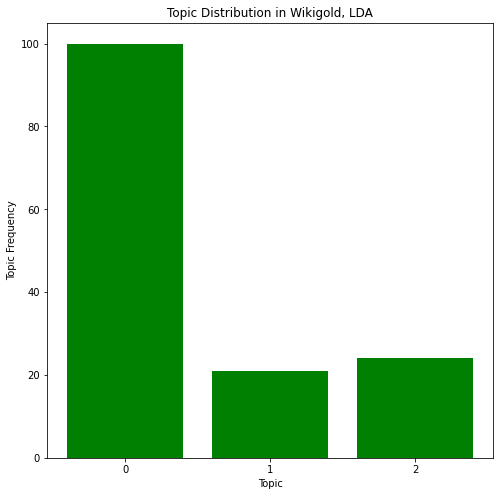

In [ ]:
my_topics = []
for i in range(len(my_count)):
  my_topics.append(f'{i}')

plt.figure(figsize=(8,8))
plt.bar(my_topics, my_count, color = "g")
plt.title("Topic Distribution in Wikigold, LDA")
plt.ylabel("Topic Frequency")
plt.xlabel("Topic")

plt.show()

<p align = "justify">The number of articles clustered in Topic 2 is the same as in LDA. The difference between the two results is in the classification of those articles which used to be in Topic 1. A substantial share of these has now been classified as belonging to Topic 0. Perhaps the vagueness (general and some specific geographical terms) of the most important terms of Topic 1 can help us understand why this change has happened.</p>

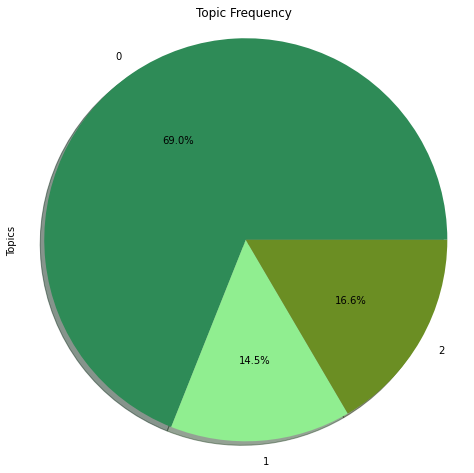

In [ ]:
count_df = pd.DataFrame(my_count, columns = ["Topics"])
count_df_labels = my_topics
count_df_colors = ['seagreen', 'lightgreen', 'olivedrab']
count_df['Topics'].plot(kind='pie',figsize=(8, 8),autopct='%1.1f%%',labels=count_df_labels, colors = count_df_colors, shadow=True)

centre_circle = plt.Circle((0, 0), 0.0, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Topic Frequency')
plt.axis('equal')

plt.show()

<p align = "justify">We can observe relative frequencies with a pie plot.</p>

Total number of tiles is 145


<Figure size 432x288 with 0 Axes>

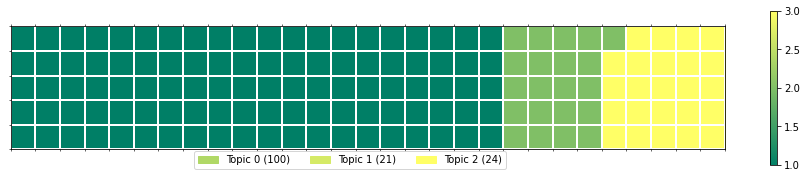

In [ ]:
width = 29
height = 5
categories = my_topics
values = count_df['Topics']
colormap = plt.cm.summer

create_waffle_chart(categories, values, height, width, colormap)

<p align = "justify">We concude this analysis by employing a waffle plot.</p>

###Term Frequency

<p align = "justify">Having looked at the most important terms per topic, we might ask ourselves which are the most common words within our whole corpus. We want to employ a maked word cloud to visualize this result, so the first thing we should do is import the module <i>wordcloud</i>. Then, we load our text, but this time considering all of it as a single string.</p>

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stri = open('wikigold_raw.txt','r', encoding="utf8")
wikigold_full = stri.read()
stri.close()

<p align = "justify">We set our stopwords as those indicated by the <i>wordcloud</i>, next, we manually remove a few terms which while not stop words do not have much meaning but pollute the rest of the analysis.</p>

In [ ]:
stopwords = set(STOPWORDS)
wikigold_full = wikigold_full.lower()
wikigold_full = wikigold_full.replace("-docstart-", "")
wikigold_full = wikigold_full.replace("one", "")
wikigold_full = wikigold_full.replace("first", "")
wikigold_full = wikigold_full.replace("two", "")

<p align = "justify">To prepare our text we tokenize and lemmatize it.</p>

In [ ]:
#tokenization
my_line = nlp(wikigold_full)
current_string = ""
#for each token in document i run this
for j in range(len(my_line)):
  #add lemmas
  current_string = current_string + " " + my_line[j].lemma_
wikigold_full = current_string
#we remove the meaningless 's term, which recurs very often
wikigold_full = wikigold_full.replace("'s", " ")

<p align = "justify">Now we can define our wordcloud. We do this by invoking the function <i>WordCloud(.)</i> the parameters of which we set to customize our output. The color of the background is set to the default white, while the maximum amount of words considered is 1500. Lastly, we exclude stopwords which might worsen our result. This should lead to a fairly representative graph.</p>
<p align = "justify">Inspired by our Japanese techno punk band, The Mad Capsule Markets, the chosen mask for our cloud was the Japanese national flag. This works as a simple and elegant mask.</p>

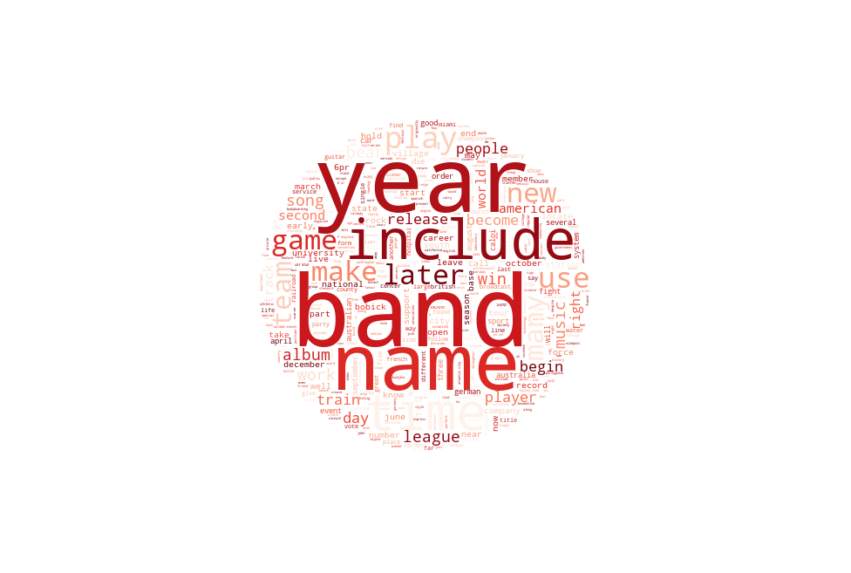

In [ ]:
from PIL import Image

japan_mask = np.array(Image.open('flag_of_japan.png'))

wiki_wc = WordCloud(
    background_color='white',
    max_words=2000,
    mask = japan_mask,
    stopwords=stopwords,
    colormap = "Reds"
)
wiki_wc.generate(wikigold_full)

fig = plt.figure(figsize=(15, 15))
plt.imshow(wiki_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<p align = "justify">We can see here our most common terms. The term "band" for example does not surprise us, keeping in mind the results of the previous analysis. Other words such as "year" and "include" seem to be of a more general nature.</p>

##RNN Approach

<p align = "justify"p>In this chapter we want to show how to utilize our pipeline to carry out a Recurrent Neural Network-based analysis on the given text. The corpus "wikigold" has been used as an example, consistently with the rest of the notebook. More precisely, several neural network architectures have been experimented, starting from a BiLSTM and then seeing if other methods (GRU, standard LSTM) could give better results consistently.</p>

<p align = "justify"p>We begin by accessing our Google Drive folder.</p>

In [ ]:
%reset -f
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Text Mining Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Text Mining Project


<p align = "justify"p>One of the first things we do is import the necessary modules for our notebook. Among these are: <i>Tensorflow</i>, more specifically <i>Keras</i>, which is going to be fundamental to implement our RNNs, <i>seqeval</i>, very useful to redact classification reports with which we can evaluate the performance of the network, and <i>numpy</i>, utilized to perform data manipulation on linear algebra objects such as matrices and tensors. From the folder <i>new_utils</i> we also call a custom-made function created to perform dataset splitting for cross-validation.</p>

In [ ]:
import urllib
import sklearn
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

!pip install seqeval
from seqeval.metrics import classification_report
from utils import dataio, kerasutils, modelutils
from new_utils import cross_validation_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU , LSTM, Embedding, Dropout, Bidirectional # , TimeDistributed
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD

import plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Pre-processing

<p align = "justify">The following line of code calls the function <i>cross_validation_split</i>. This comes from the aforementioned folder <i>new_utils</i>. The function splits the dataset into training, validation and test sets. The following parameters define the behaviour of the function:</p>

*   Text name, which now is <i>wikigold.txt</i>;
*   Folder in which to deploy the resulting split dataset (in three .txt files), now the folder is <i>datasets</i>;
*   Validation and test set percentage, now both are 20% (so the training set is 60%);
*   <i>True</i>, which indicates to our function to show us how many documents per dataset are being included.

<p align = "justify">The function operates by considering the number of documents included within our dataset (the separator considered is <i>-DOCSTART-</i> ), and then randomly drawing among them to split.</p>

In [ ]:
#cross_validation_split.train_valid_test('wikigold.txt', 'datasets', 0.2, 0.2, True)

train: 87;
validation: 29;
test: 29


<p align = "justify">What we now need to do is divide our documents in sentences, this also helps us gauge how our cross-validation split has been performed, and if there is an imbalance we should be concerned about. If there is, then we can always re-run the previous function until we get a satisfying result. Although it has not been necessary as a practice for <i>wikigold</i>, the user might have some very small or very large documents that can worsen overall performance.</p>

In [ ]:
data_dir = os.path.join('datasets')
raw_train, ner_train, output_labels, sent_len_tr = dataio.load_conll_data('train.txt', dir_path=data_dir, only_tokens=True)
raw_valid, ner_valid, _ , sent_len_val = dataio.load_conll_data('valid.txt', dir_path=data_dir, only_tokens=True)
raw_test, ner_test, _, sent_len_test = dataio.load_conll_data('test.txt', dir_path=data_dir, only_tokens=True)

Reading file datasets/train.txt
Read 1063 sentences
Reading file datasets/valid.txt
Read 384 sentences
Reading file datasets/test.txt
Read 249 sentences


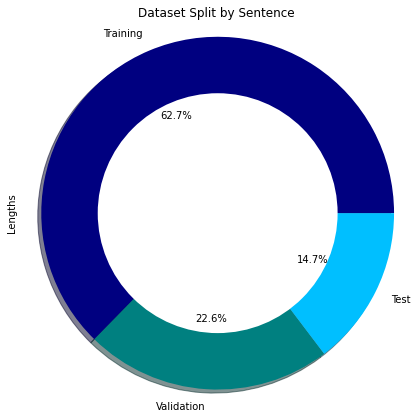

In [ ]:
sentence_len = [sent_len_tr, sent_len_val, sent_len_test]
len_df = pd.DataFrame(sentence_len, columns = ["Lengths"])
len_df_labels = ["Training", "Validation", "Test"]
len_df_colors = ['navy', 'teal', 'deepskyblue']
len_df['Lengths'].plot(kind='pie',figsize=(7, 7),autopct='%1.1f%%',labels=len_df_labels, colors = len_df_colors, shadow=True)

centre_circle = plt.Circle((0, 0), 0.680, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Dataset Split by Sentence')
plt.axis('equal')

plt.show()

<p align = "justify">We can see here the first sentence of our training set (obviously it is subject to change each time the dataset is split) with relative IOB annotations.</p>

In [ ]:
print(raw_train[0])
print(ner_train[0])

['010', 'is', 'the', 'tenth', 'album', 'from', 'Japanese', 'Punk', 'Techno', 'band', 'The', 'Mad', 'Capsule', 'Markets', '.']
['I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']


<p align = "justify">We now encode our sequences using the function <i>Tokenizer</i>. To each tag we associate an id, we can go from one to the other and viceversa. This process is performed on training, validation and test sets.</p>

In [ ]:
# integer encode sequences of words
token_tokenizer = Tokenizer()    # Automatically lowers tokens
token_tokenizer.fit_on_texts(raw_train + raw_valid + raw_test)

train_sequences = token_tokenizer.texts_to_sequences(raw_train)
test_sequences = token_tokenizer.texts_to_sequences(raw_test)
valid_sequences = token_tokenizer.texts_to_sequences(raw_valid)

tag2idx = { tag: idx for idx, tag in enumerate(output_labels) } #when we have the tag we want the id
idx2tag = { idx: tag for tag, idx in tag2idx.items() } #when we have the id we want to go to the tag

ner_train_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_train]
ner_test_sequences  = [[tag2idx[tag] for tag in sentence] for sentence in ner_test ]
ner_valid_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_valid]
vocabulary_size = len(token_tokenizer.word_counts)

<p align = "justify">We can now show an encoded sentence from the validation set.</p>

In [ ]:
print(raw_valid[0])
print(valid_sequences[0])
for i in valid_sequences[0]:
    print(f'{i} : {token_tokenizer.index_word[i]}')

['The', 'Centennial', 'Convention', 'Hall', 'is', 'located', 'in', 'Hayward', ',', 'California', 'and', 'is', 'part', 'of', 'the', 'Hayward', 'City', 'Center', 'district', 'of', 'Hayward', '.']
[1, 1411, 445, 300, 11, 114, 5, 1058, 2, 263, 6, 11, 138, 4, 1, 1058, 77, 184, 404, 4, 1058, 3]
1 : the
1411 : centennial
445 : convention
300 : hall
11 : is
114 : located
5 : in
1058 : hayward
2 : ,
263 : california
6 : and
11 : is
138 : part
4 : of
1 : the
1058 : hayward
77 : city
184 : center
404 : district
4 : of
1058 : hayward
3 : .


<p align = "justify">Our text is divided in sentences, or sequences. Due to how the RNN architectures run, we need all of these to be of the same length. This is of course not possible and we need to follow a procedure called <i>padding</i>. Before implementing this, though, we need to perform some exploratory analysis on the length of our sequences so that we can best decide how to act.</p>
<p align = "justify">We print both the average (rounded to two digits) and maximum length of our sequences.</p>

In [ ]:
sequence_len = np.array([len(s) for s in train_sequences])
mean_sequence = round(sequence_len.mean(), 2)
longest_sequence = sequence_len.max()
print(f'Mean sequence: {mean_sequence}')
print(f'Longest sequence: {longest_sequence}')

Mean sequence: 22.94
Longest sequence: 86


<p align = "justify">We can perform a more in-depth analysis by printing the percentiles of our sequence lengths. The idea is to include most of our sequences but not the longest ones so as to not have too much padding.</p>

In [ ]:
print([(str(new_p) + '%', np.percentile(sequence_len, new_p)) for new_p in range(75,101, 5)])

[('75%', 29.0), ('80%', 31.0), ('85%', 35.0), ('90%', 40.0), ('95%', 48.0), ('100%', 86.0)]


<p align = "justify">Here we decide up to which length we want to include sequences. This parameter might be chosen manually, but it was decided to include a more streamlined approach that considers the 90th percentile and then averages it with the maximum value of the length. This perhaps is not the best approach for every case, but it should avoid extreme results and let the user worry about one less parameter to tune. Should the user favour a more direct approach, the last (commented) line lets him do so.</p>

In [ ]:
my_perc = 90
max_sequence_len = int((np.percentile(sequence_len, my_perc) + longest_sequence)/2)
print(f"Chosen maximum sequence size: {max_sequence_len}")

#max_sequence_len = 55

Chosen maximum sequence size: 63


<p align = "justify">If we wanted to visualize how many documents we are actually considering with our <i>max_sequence_len</i> cutoff point, we could build a histogram in which a vertical line represents our threshold. The following plot serves exactly this purpose.</p>

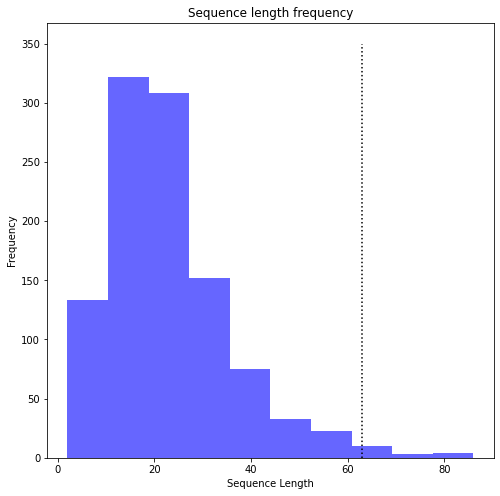

In [ ]:
percentiles = []
percentages = []
for new_p in range(0,101,1):
  percentages.append(new_p)
  percentiles.append(np.percentile(sequence_len, new_p))

plt.figure(figsize=(8,8))
plt.hist(sequence_len, color = "b", alpha = 0.6)
plt.plot((max_sequence_len, max_sequence_len), (0, 350), linestyle = "dotted", color = "k")

plt.title("Sequence length frequency")
plt.ylabel("Frequency")
plt.xlabel("Sequence Length")

plt.show()

<p align = "justify">The graph shows us that we are going to be using the vast majority of our documents.</p>

In [ ]:
X_train = pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_valid = pad_sequences(valid_sequences, maxlen=max_sequence_len, padding='post', truncating='post')

Y_train = pad_sequences(ner_train_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_test = pad_sequences(ner_test_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_valid = pad_sequences(ner_valid_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')

Y_train = to_categorical(Y_train, num_classes=len(output_labels), dtype='int32')
Y_test = to_categorical(Y_test, num_classes=len(output_labels), dtype='int32')
Y_valid = to_categorical(Y_valid, num_classes=len(output_labels), dtype='int32')

<p align = "justify">The padding character is "_PAD_", we set it as such here.</p>

In [ ]:
token_tokenizer.index_word[0] = '_PAD_'

<p align = "justify">We can now transform our sets into <i>numpy</i> arrays. We then print the shapes, for example, of input and response variables of our validation set.</p>

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

#validation set dimensions
print(X_valid.shape)
print(Y_valid.shape)

(384, 63)
(384, 63, 5)


<p align = "justify">We have concluded the pre-processing part of our RNN approach. We can now focus on training and tuning our model.</p>

###Recurrent Neural Network

<p align = "justify">The first choice that must be made is whether to apply GloVe embedding or not. This can be done quite simply by setting the boolean variable <i>glove</i> to <i>True</i>. While this is the default in our case, the user might decide against it. For <i>wikigold</i> it is a necessary passage, as network performance sharply decreases if GloVe embedding is not introduced and a local embedding based only on our data is instead considered.</p>

In [ ]:
glove=True

<p align = "justify">If we decided for using GloVe, the embedding is loaded in from the <i>embeddings</i> folder after an empty matrix is initialized. We can then set the embedding size and finally input GloVe within our matrix.</p>

In [ ]:
glove_matrix=None
if glove:
  glove_embedding_path = os.path.join('embeddings', 'glove.6B.100d.txt') #this embedding has 6 Billion tokens
  embedding_dim = 100
  glove_matrix = kerasutils.load_glove_embedding_matrix(glove_embedding_path, token_tokenizer.word_index, embedding_dim)

Found 400001 word vectors.


<p align = "justify">In the following sizeable chunk of code the Recurrent Neural Network is established. The function was moved from a file found in the folder <i>utils</i> to this main one so as to make tuning and modifying the network more accessible to the user as well as to us. We now detail the function structure.</p>
<p align = "justify">If the GloVe embedding was utilized, then we add an embedding layer based on it. Otherwise, an embedding layer based on our vocabulary size and embedding dimension is set. For our corpus, <i>wikigold</i>, GloVe was necessary to not see our evaluation metrics drop significantly and consistently (even among different dataset splits).</p>
<p align = "justify">The previous step is followed by a dropout layer. The dropout percentage is an important hyperparameter to tune, we started from 0.4 and then proceeded to try and increase it to 0.5. This led to a sharp drop in peformance, so we walked back to a less drastic measure, finally setting for a 0.35 dropout. A dropout layer removes part of the data flowing through our network and helps avoid overfitting. The goal is always to be able to generalize our findings and not to simply adhere perfectly to the training set.</p>
<p align = "justify">Bidirectional LSTM nodes are the core of our network. A lengthy tuning process has gone into this choice. Performance wise, the only other comparable layer type is the LSTM. Adding more than two BiLSTM or LSTM layers makes the network perform worse in the prediction phase, as well as leading the training phase taking much longer. Using GRU instead of an LSTM approach also leads to a sharp decrease in performance.</p>
<p align = "justify">To perform any prediction, we need a classification layer. The two choices which seem to perform well are a <i>sigmoid</i> or <i>softmax</i> layers. Both were tested and, in our case, seem to work rather well.</p>
<p align = "justify">We need to choose the optimizer with which to set the best weights for our model. The main choices would be Stochastic Gradient, or Adam (it uses diagonal scaling and momentum based techniques to give better results). Adam is the state-of-the-art choice and indeed it performs considerably better than the SGD.</p>
<p align = "justify">Finally, we decide our evaluation metrics, accuracy, precision and recall in our case, and output a model summary.</p>

In [ ]:
#wikigold_RNN is a modified version of the create_paper_BiLSTM function
def wikigold_RNN(vocabulary_size, seq_len, n_classes, hidden_cells=150,
                  embed_dim=100, drop=0.35, use_glove=False, glove_matrix=None):
    """Create a Recurrent Neural Network to analyse and classify wikigold labels"""
    model = Sequential()
    if use_glove: #if glove is used we configure the embedding with the weights given by glove
        model.add(Embedding(vocabulary_size, embed_dim,
                            weights=[glove_matrix], input_length=seq_len,
                            mask_zero=True, trainable=True))
    else: #otherwise we add embedding that relies on keras, so using vectors created by Keras
        model.add(Embedding(vocabulary_size, embed_dim, input_length=seq_len, 
                            mask_zero=True)) #we just define a vocab. size, the size of input length and mask zero
        #input length is set because the embedding is the 1st layer of the network
    model.add(Dropout(drop)) #we "smooth" the model with a dropout layer
    model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True, 
                                 dropout=drop)))
    model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True, 
                                 dropout=drop)))
    
    model.add(Dense(n_classes, activation='softmax')) #one softmax layer only, it is our classification step
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
#                   optimizer=SGD(learning_rate=0.015, momentum=0.9, clipvalue=5.),  # decay rate missing
                  metrics=['accuracy', #this is where we define our metrics: accuracy, precision, and recall.
                           Precision(),
                           Recall()])
    model.summary()
#     plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model

<p align = "justify">In this chunk we define as <i>model</i> the function specified above. We also establish a checkpoint system which, given the folder <i>RNN_models</i> for each epoch chooses whether to save it or not. Saving a model is useful for several reasons. First, in case of a system shutdown we do not lose completely the work done in the training phase, also, the last iteration of our RNN might not be the best one according to the chosen metrics of evaluation.</p>
<p align = "justify">The output is a simple text-based description of the chosen Neural Network architecture.</p>

In [ ]:
model = wikigold_RNN(vocabulary_size+1, max_sequence_len, len(output_labels), 
                                 embed_dim=100, use_glove=glove, glove_matrix=glove_matrix)

best_model_file = os.path.join('RNN_models','TA-800_RNN_best_model.h5')
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=True, #we are saving only the weights not the tokens
    save_best_only=True #we are saving only the best model, the last one at the training step
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 100)           772600    
                                                                 
 dropout (Dropout)           (None, 63, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 63, 300)          301200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 63, 300)          541200    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 63, 5)             1505      
                                                                 
Total params: 1,616,505
Trainable params: 1,616,505
Non-

<p align = "justify">Another useful tool we introduce is an early stopping system. This allows us to have our network stop its training phase before reaching the last epoch, if the loss function related to the validation set does not improve by a certain amount specified by us in the variable <i>min_improve</i>.

In [ ]:
min_improve = 0.001
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=min_improve, patience=3, verbose=1, mode="auto", restore_best_weights=True)

<p align = "justify">We can now actually run our model. For each iteration (or epoch), the system outputs the relative metrics. The one we chose to monitor was the <i>val_loss</i>. Also, the time required for each iteration is included, and this is subject to sharp change depending on the architecture that we choose to apply. While in our case the execution time is negligible, this might scale rapidly with dataset size, so while in absolute terms the time required per iteration is always low (from 30 seconds to 120 seconds), a measure of attention should be maintained.</p>
<p align = "justify">The more important parameter to tune is the batch size, indicated by the variable <i>batch_size</i>. This is of course related to the optimization phase of the network. A batch size higher than 6 in our case leads to performance decrease, while setting as low as 1 does not seem to improve significantly performance, while increasing sensibly the execution time. The value of 4 in our case seems to be the best alternative.</p>

In [ ]:
%%time
batch_size = 4
history = model.fit(X_train, 
          Y_train, 
          batch_size=batch_size, 
          epochs=20,
          verbose=2,
          callbacks=[checkpoint, early_stopping_callback],
          validation_data=(X_valid, Y_valid)
         )

Epoch 1/20
266/266 - 110s - loss: 0.1658 - accuracy: 0.8658 - precision: 0.8922 - recall: 0.8390 - val_loss: 0.1225 - val_accuracy: 0.8927 - val_precision: 0.9202 - val_recall: 0.8696 - 110s/epoch - 413ms/step
Epoch 2/20
266/266 - 90s - loss: 0.1163 - accuracy: 0.8960 - precision: 0.9201 - recall: 0.8734 - val_loss: 0.1039 - val_accuracy: 0.9098 - val_precision: 0.9328 - val_recall: 0.8914 - 90s/epoch - 338ms/step
Epoch 3/20
266/266 - 88s - loss: 0.0923 - accuracy: 0.9155 - precision: 0.9350 - recall: 0.8987 - val_loss: 0.0942 - val_accuracy: 0.9178 - val_precision: 0.9374 - val_recall: 0.9021 - 88s/epoch - 329ms/step
Epoch 4/20
266/266 - 88s - loss: 0.0802 - accuracy: 0.9265 - precision: 0.9403 - recall: 0.9121 - val_loss: 0.0923 - val_accuracy: 0.9229 - val_precision: 0.9371 - val_recall: 0.9103 - 88s/epoch - 330ms/step
Epoch 5/20
266/266 - 88s - loss: 0.0647 - accuracy: 0.9415 - precision: 0.9521 - recall: 0.9322 - val_loss: 0.0889 - val_accuracy: 0.9264 - val_precision: 0.9358 - va

<p align = "justify">After having run our model, we can proceed to evaluate it.</p>

###Evaluation
<p align = "justify">The first metric we wish to check on is the size of our model. In our case it is usually of a few megabytes. How big a model is can be a deciding factor in choosing on which hardware it can be deployed, so it should not be discarded.</p>

In [ ]:
kerasutils.print_model_memory_usage(batch_size, model)

Model size: 6.94 MB


<p align = "justify">Next, we can see how much time is needed to perform token classification. More specifically, to vectorize the tokens and perform prediction.</p>

In [ ]:
print(f'Model latency in predictions: {modelutils.compute_prediction_latency(X_test, model):.3} s')

8/8 [==============================] - 8s 191ms/step
Model latency in predictions: 0.0369 s


<p align = "justify">The following chunk of code is especially important. We call the <i>classification_report</i> function from <i>seqeval</i> and with it we try to gather information on how our model has managed to perform prediction. The evaluation is based on training, validation and test sets. The first thing we can see is that the model naturally performs better on the training set compared to the others. This is to be expected on some level, but the difference between, for example, training precision and validation precision leads us to believe the model might be overfitting. Increasing dropout though did not help and infact made the situation worse. This trend is followed in the test set. In short, our model is unable to generalize perfectly its predictive capability for the labels I-ORG and I-MISC. It acts much better for the labels I-LOC and I-PER.</p>

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Validation Set', X_valid, Y_valid), ('Test Set', X_test, Y_test)]

for title, X, Y in datasets:
    Y_pred = model.predict(X, batch_size=batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = kerasutils.remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = modelutils.from_encode_to_literal_labels(Y, Y_pred, idx2tag)
    
    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

266/266 [==============================] - 13s 49ms/step


/content/drive/MyDrive/Text Mining Project/utils/kerasutils.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_true), np.array(new_pred)


Training Set
              precision    recall  f1-score   support

         LOC      0.809     0.859     0.833       630
        MISC      0.658     0.659     0.658       513
         ORG      0.660     0.570     0.612       437
         PER      0.948     0.922     0.935       615

   micro avg      0.785     0.772     0.779      2195
   macro avg      0.769     0.752     0.759      2195
weighted avg      0.783     0.772     0.777      2195



96/96 [==============================] - 5s 49ms/step
Validation Set
              precision    recall  f1-score   support

         LOC      0.766     0.705     0.734       200
        MISC      0.257     0.360     0.300       100
         ORG      0.416     0.303     0.350       228
         PER      0.815     0.753     0.783       170

   micro avg      0.578     0.536     0.556       698
   macro avg      0.564     0.530     0.542       698
weighted avg      0.591     0.536     0.558       698



63/63 [==============================] - 3s 

<p align = "justify">What we can do now is to try and visualize our result to get a more intuitive grasp on the situation. We do this through a confusion matrix, which considers each token of the test set independently and confronts its predicted label with its true label. The goal is to have a general idea of why we are failing to predict labels such as I-MISC and I-ORG consistently.</p>
<p align = "justify">We first want to make sure we are looking at the correct subset of our data.</p>

In [ ]:
print(title)

Test Set


<p align = "justify">We then proceed by extracting each token and relative label one by one from our results so as to be able to consider them independently. Then, a function relying on the <i>sklearn</i> module for a confusion matrix is defined and finally called.</p>

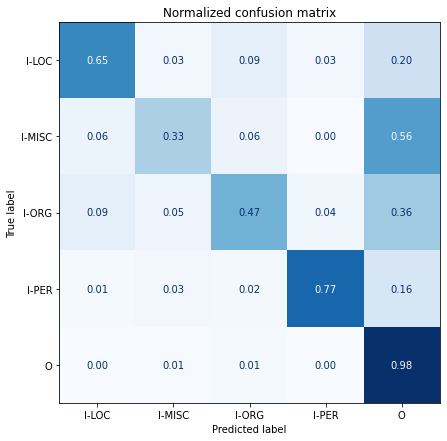

In [ ]:
single_list_true = []
single_list_pred = []
for i in range(len(let_y_true)):
  for j in range(len(let_y_true[i])):
    single_list_true.append(let_y_true[i][j])

for i in range(len(let_y_pred)):
  for j in range(len(let_y_pred[i])):
    single_list_pred.append(let_y_pred[i][j])

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = ["I-LOC", "I-MISC", "I-ORG", "I-PER", "O"]
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(7, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    

plot_confusion_matrix(single_list_pred, single_list_true, labels)

<p align = "justify">The confusion matrix does well in letting us understand how the O label is the problem. More specifically, its sample size is magnitudes larger than for the other labels and the model suffers from this imbalance. It is therefore not surprising to see how the vast majority of I-MISC false negatives are instead classified as O. This holds true also for other labels. Perhaps the difference between I-MISC and other labels, such as I-PER, might be due to the fact that a token considered as I-MISC has, due to the very nature of the label, a weaker connotation within the sentence and vocabulary. It might be harder to find and classify.</p>

<p align = "justify">The final thing we might do is to see how our model performs on a single sentence from the test set.</p>

In [ ]:
i = 0
sentence = X_test[i]
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_pred = y_pred[i]
y_true = np.argmax(Y_test, axis=-1)[i]
for idx in range(len(sentence)):
  if token_tokenizer.index_word[sentence[idx]] != "_PAD_":
    print(f'{token_tokenizer.index_word[sentence[idx]]:15}  {idx2tag[y_true[idx]]:6} | {idx2tag[y_pred[idx]]}')

8/8 [==============================] - 2s 195ms/step
albert           I-PER  | I-PER
wren             I-PER  | I-PER
was              O      | O
an               O      | O
ontario          I-LOC  | I-LOC
politician       O      | O
.                O      | O


<p align = "justify">In this chapter we have successfully applied a Recurrent Neural Network to perform a Named Entity Recognition prediction task on our corpus. The results for two of the given four labels, I-MISC and I-ORG are not great, but they are significantly better on labels I-LOC and I-PER. We are going to try and improve upon this by applying an encoder-decoder architecture: Bert.</p>

##BERT

In [ ]:
%reset -f
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Text Mining Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Text Mining Project


In [ ]:
import random
import pandas as pd
import numpy as np
import os
from utils import dataio
from utils import dataio, kerasutils, modelutils
!pip install torch
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from tqdm import tqdm
!pip install seqeval
from seqeval.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Pre-processing

We load the dataset and extract from it raw text and labels. We have a total of 1696 sentences.

In [ ]:
data_dir = os.path.join('')
raw_train, ner_train, output_labels, sent_len_tr = dataio.load_conll_data('wikigold.txt', dir_path=data_dir, only_tokens=True)
train_list = []
for i in range(len(raw_train)):
  train_list.append([raw_train[i], ner_train[i]])
df_train = pd.DataFrame (train_list, columns = ['text', 'label'])

Reading file wikigold.txt
Read 1696 sentences


Now, we put together word by word the sentences and compile them into a pandas dataframe.

In [ ]:
raw_text = []
for i in range(len(raw_train)):
  current_string = ""
  for j in range(len(raw_train[i])):
    current_string = current_string + " " + raw_train[i][j]
  raw_text.append(current_string)

raw_labels = []
for i in range(len(raw_train)):
  current_string = ""
  for j in range(len(raw_train[i])):
    current_string = current_string + " " + ner_train[i][j]
  raw_labels.append(current_string)

train_list = []
for i in range(len(raw_train)):
  train_list.append([raw_text[i], raw_labels[i]])
df_train = pd.DataFrame (train_list, columns = ['text', 'label'])
df_train

,text,label
0,010 is the tenth album from Japanese Punk Tec...,I-MISC O O O O O I-MISC O O O I-ORG I-ORG I-O...
1,This album proved to be more commercial and m...,O O O O O O O O O O O I-MISC O O O O O O I-MI...
2,Founding member Kojima Minoru played guitar o...,O O I-PER I-PER O O O I-MISC I-MISC O O I-MIS...
3,"XXX can of This had a different meaning , and...",I-MISC I-MISC I-MISC I-MISC O O O O O O O O O...
4,it was later explained that the song was abou...,O O O O O O O O O I-MISC O O O O O O O O I-MI...
...,...,...
1691,This major has been gaining recognition for F...,O O O O O O O I-ORG O O O O O O O O O
1692,The Robert C. Byrd National Aerospace Educati...,O I-ORG I-ORG I-ORG I-ORG I-ORG I-ORG I-ORG O...
1693,"Fairmont State 's athletic teams , known as t...",I-ORG I-ORG O O O O O O O I-ORG O O O O I-ORG...
1694,A list of works by Justin Broadrick .,O O O O O I-PER I-PER O


In [ ]:
labels = [i.split() for i in df_train['label'].values.tolist()]

# Check how many labels are there in the dataset
unique_labels = set()

for lb in labels:
  [unique_labels.add(i) for i in lb if i not in unique_labels]
 
print(unique_labels)

{'I-LOC', 'I-ORG', 'O', 'I-MISC', 'I-PER'}


We have 5 unique labels.

In [ ]:
# Map each label into its id representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}
print(labels_to_ids)

{'I-LOC': 0, 'I-MISC': 1, 'I-ORG': 2, 'I-PER': 3, 'O': 4}


Before we are able to use a BERT model to classify the entity of a token, of course, we need to do data preprocessing first, which includes two parts: tokenization and adjusting the label to match the tokenization. 

In [ ]:
text = df_train['text'].values.tolist()
example = text[0]
print(example)

 010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets .


In [ ]:
!pip install transformers
from transformers import BertTokenizerFast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
text_tokenized = tokenizer(example, padding='max_length', max_length=63, truncation=True, return_tensors="pt")
print(tokenizer.decode(text_tokenized.input_ids[0]))

[CLS] 010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
#Adjusting Label After Tokenization
print(tokenizer.convert_ids_to_tokens(text_tokenized["input_ids"][0]))

['[CLS]', '01', '##0', 'is', 'the', 'tenth', 'album', 'from', 'Japanese', 'Punk', 'Tech', '##no', 'band', 'The', 'Mad', 'Cap', '##sul', '##e', 'Markets', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


### Network Definition
Before we train our BERT model for NER task, we need to create a dataset class to generate and fetch data in a batch.



In [ ]:
def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

In [ ]:
class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df_train):

        lb = [i.split() for i in df_train['label'].values.tolist()]
        txt = df_train['text'].values.tolist()
        self.texts = [tokenizer(str(i),padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In the code snippet above, we tokenize our input texts, and we use align_label function to adjust our label after tokenization process.



In [ ]:
# Let's split in train,validation and test sets.

df_train1, df_val, df_test = np.split(df_train.sample(frac=1, random_state=88),[int(.7 * len(df_train)), int(.85 * len(df_train))])

As you can see we have 2 columns with texts and labels respectively 

In [ ]:
#Create a function for Bert algorithm 
from transformers import BertForTokenClassification

class BertModel(torch.nn.Module):

    def __init__(self):

        super(BertModel, self).__init__()

        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):

        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

We create a "train_loop" function in order to summarize the weights  minimization process throught backpropagation and the computation of train and test accurancy 

In [ ]:
def train_loop(model, df_train1, df_val):

    train_dataset = DataSequence(df_train1)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(df_val)
        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train1): .3f} | Accuracy: {total_acc_train / len(df_train1): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')

In [ ]:
LEARNING_RATE = 0.01
EPOCHS = 8
BATCH_SIZE = 4

In [ ]:
model = BertModel()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
train_loop(model, df_train1, df_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 297/297 [01:43<00:00,  2.86it/s]


Epochs: 1 | Loss:  0.403 | Accuracy:  0.881 | Val_Loss:  0.270 | Accuracy:  0.918


100%|██████████| 297/297 [01:42<00:00,  2.89it/s]


Epochs: 2 | Loss:  0.245 | Accuracy:  0.928 | Val_Loss:  0.227 | Accuracy:  0.934


100%|██████████| 297/297 [01:42<00:00,  2.89it/s]


Epochs: 3 | Loss:  0.199 | Accuracy:  0.940 | Val_Loss:  0.194 | Accuracy:  0.940


100%|██████████| 297/297 [01:42<00:00,  2.90it/s]


Epochs: 4 | Loss:  0.170 | Accuracy:  0.949 | Val_Loss:  0.197 | Accuracy:  0.938


100%|██████████| 297/297 [01:42<00:00,  2.89it/s]


Epochs: 5 | Loss:  0.144 | Accuracy:  0.956 | Val_Loss:  0.188 | Accuracy:  0.943


100%|██████████| 297/297 [01:42<00:00,  2.89it/s]


Epochs: 6 | Loss:  0.123 | Accuracy:  0.962 | Val_Loss:  0.186 | Accuracy:  0.943


100%|██████████| 297/297 [01:42<00:00,  2.90it/s]


Epochs: 7 | Loss:  0.111 | Accuracy:  0.966 | Val_Loss:  0.190 | Accuracy:  0.944


100%|██████████| 297/297 [01:42<00:00,  2.89it/s]


Epochs: 8 | Loss:  0.094 | Accuracy:  0.970 | Val_Loss:  0.192 | Accuracy:  0.945


###Evaluation

Now that we have trained our model, we can evaluate its performance on unseen test data.

In [ ]:
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)
    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0
    my_true = []
    my_pred = []
    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)

            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)
            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]
              predictions = logits_clean.argmax(dim=1)

              label_clean_cpu = label_clean.cpu()
              my_true.append(list(label_clean_cpu.numpy()))

              predictions_cpu = predictions.cpu()
              my_pred.append(list(predictions_cpu.numpy()))

              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    #print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')
    return my_true, my_pred

y_true, y_pred = evaluate(model, df_test)

In [ ]:
let_y_true, let_y_pred = modelutils.from_encode_to_literal_labels(y_true, y_pred, ids_to_labels)

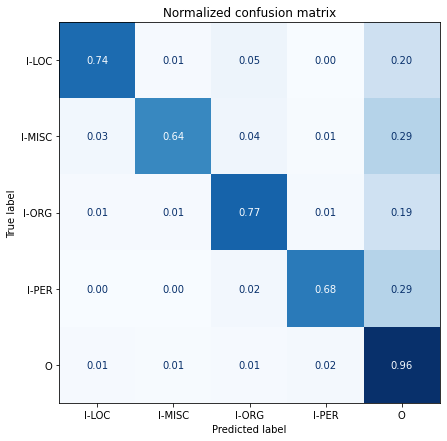

In [ ]:
import matplotlib.pyplot as plt

single_list_true = []
single_list_pred = []
for i in range(len(y_true)):
  for j in range(len(y_true[i])):
    single_list_true.append(y_true[i][j])

for i in range(len(y_pred)):
  for j in range(len(y_pred[i])):
    single_list_pred.append(y_pred[i][j])


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = ["I-LOC", "I-MISC", "I-ORG", "I-PER", "O"]
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(7, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    

plot_confusion_matrix(single_list_pred, single_list_true, labels)

In [ ]:
print(classification_report(let_y_true, let_y_pred, digits=3))

              precision    recall  f1-score   support

         LOC      0.654     0.627     0.640       169
        MISC      0.624     0.582     0.602        91
         ORG      0.591     0.653     0.620       144
         PER      0.590     0.540     0.564       189

   micro avg      0.613     0.599     0.606       593
   macro avg      0.615     0.601     0.607       593
weighted avg      0.614     0.599     0.605       593



In [ ]:
def align_word_ids(texts):
  
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

In [ ]:
def evaluate_one_text(model, sentence):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    print(sentence)
    print(prediction_label)

We evaluate a single sentence containing all of the IOB labels.

In [ ]:
evaluate_one_text(model, "Japan's football team, the Samurai Blue, beat Germany last week at the World Cup,")
evaluate_one_text(model, "the Japanese head coach Haijime Moriyasu was very happy about the result.")

Japan's football team, the Samurai Blue, beat Germany last week at the World Cup,
['I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'I-MISC', 'I-MISC', 'O']
the Japanese head coach Haijime Moriyasu was very happy about the result.
['O', 'I-MISC', 'O', 'O', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


The classification results and metrics have improved significantly compared to our previous Recurrent Neural Network approach.

##Conclusion
<p align = "justify">The goal of this notebook was to provide a ready-made NLP pipeline. We began by defining EDA elements, such as part-of-speech tagging, named entity analysis, topics modelling methods and finally a quick study of term frequency. An effort was then made to apply a Recurrent Neural Network, with BiLSTM layers, to a named entity recognition task, with imperfect results. Finally, by using the BERT transformer, we managed to improve our NER results and classify adequately our corpus.</p>